In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import warnings
sns.set_style('darkgrid')

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
!head heart_failure_clinical_records_dataset.csv

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1
75,1,246,0,15,0,127000,1.2,137,1,0,10,1
60,1,315,1,60,0,454000,1.1,131,1,1,10,1
65,0,157,0,65,0,263358.03,1.5,138,0,0,10,1


In [3]:
data = 'heart_failure_clinical_records_dataset.csv'

df = pd.read_csv(data, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Citing the paper from Chicco and Jurman (2020), some of feature columns hold the representation of presence of event in boolean form: `anemia`, `diabetes`, `high_blood_pressure`, `smoking`, and `DEATH_EVENT`. Feature `sex` is the only one that does belong to binary type since it holds value of patients' gender. 

These columns, in pandas view of point, are intrepeted as integers by default (with the condition that their features are filled by either 0 or 1). To render this data to be more sensible for building predictive models, value modification can be done with dictionary mapping so that each of the feature a patient entitled to is marked as `yes` and `no` otherwise.

### Data Preprocessing

Information given from `df.info()` shows that heart failure dataset is completely from missing data. However, for columns holding binary/boolean data in numerical type is a little concern. Thus, we will convert these columns into categorical type.

In [4]:
cat_cols = list(filter(lambda x: x if len(df[x].unique()) <= 2 else None, df.columns))
df[cat_cols] = df[cat_cols].astype('category')

In [5]:
boolean_values = {
    1: 'yes',
    0: 'no'
}

sex_values = {
    1: 'male',
    0: 'female'
}

for x in cat_cols:
    if x != "sex":
        df[x] = df[x].map(boolean_values)
    else:
        df[x] = df[x].map(sex_values)

In [6]:
df['sex'].value_counts()

male      194
female    105
Name: sex, dtype: int64

In [7]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,no,582,no,20,yes,265000.00,1.9,130,male,no,4,yes
1,55.0,no,7861,no,38,no,263358.03,1.1,136,male,no,6,yes
2,65.0,no,146,no,20,no,162000.00,1.3,129,male,yes,7,yes
3,50.0,yes,111,no,20,no,210000.00,1.9,137,male,no,7,yes
4,65.0,yes,160,yes,20,no,327000.00,2.7,116,female,no,8,yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       299 non-null    float64 
 1   anaemia                   299 non-null    category
 2   creatinine_phosphokinase  299 non-null    int64   
 3   diabetes                  299 non-null    category
 4   ejection_fraction         299 non-null    int64   
 5   high_blood_pressure       299 non-null    category
 6   platelets                 299 non-null    float64 
 7   serum_creatinine          299 non-null    float64 
 8   serum_sodium              299 non-null    int64   
 9   sex                       299 non-null    category
 10  smoking                   299 non-null    category
 11  time                      299 non-null    int64   
 12  DEATH_EVENT               299 non-null    category
dtypes: category(6), float64(3), int64(4)
memory usage:

### Exploratory Data Analysis

What will be explored in this section:
   - Composition of patients' survival by gender
   - Proportion of `DEATH_EVENT` against categorical variables
   - Feature importance
   - Feature correlation
   
#### Composition of patients' survival by gender

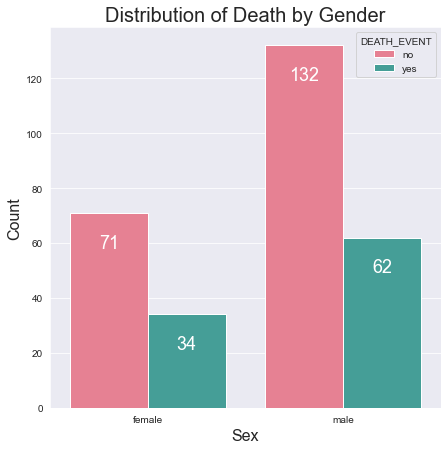

In [10]:
plt.figure(figsize=(7,7))

ax = sns.countplot(x="sex", hue="DEATH_EVENT", data=df, palette="husl")
ax.set_title('Distribution of Death by Gender', fontsize=20)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
plt.xlabel('Sex', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

#### Proportion of `DEATH_EVENT` against categorical variables

In [13]:
df["DEATH_EVENT_int"] = (df["DEATH_EVENT"] == 'yes').astype(int)
global_mean = df["DEATH_EVENT_int"].mean()
round(global_mean, 3)

0.321

In [14]:
female_mean = df[df.sex == 'female']["DEATH_EVENT_int"].mean()
print('gender == female:', round(female_mean, 3))

male_mean = df[df.sex == 'male']["DEATH_EVENT_int"].mean()
print('gender == male:  ', round(male_mean, 3))

gender == female: 0.324
gender == male:   0.32


Comparing to the global mean, difference between the group rates for both females and males is as close as being negligible, indicating that status accounted by gender is not much of a help in calculating the chance of death risk.

In [16]:
global_mean = df["DEATH_EVENT_int"].mean()
categorical = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

for col in categorical:
    df_group = df.groupby(by=col)["DEATH_EVENT_int"].agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
anaemia,,,
no,0.294118,-0.026953,0.916054
yes,0.356589,0.035519,1.110627


,mean,diff,risk
diabetes,,,
no,0.321839,0.000769,1.002395
yes,0.320000,-0.001070,0.996667


,mean,diff,risk
high_blood_pressure,,,
no,0.293814,-0.027256,0.915110
yes,0.371429,0.050358,1.156845


,mean,diff,risk
sex,,,
female,0.323810,0.002739,1.008532
male,0.319588,-0.001483,0.995382


,mean,diff,risk
smoking,,,
no,0.325123,0.004053,1.012623
yes,0.312500,-0.008570,0.973307


What we obtain from calculating group risk factor for each categorical feature and comparing its proportion against risk of an entire population is that we can figure out how far that the presence of ailment/smoking habit affects the risk of death from heart failure.

   - Patients suffering anaemia tend to have higher risk than those who do not: the risk of mortality is 1.11 for anameia group against 0.916 for all patient not being treated as to having anaemia.
   - Risk is higher for everyone that suffered from high blood pressure, in which its marginal proportion is 1.15. Meanwhile, people whose free from this ailment have lower risk (0.916).
   - Risk differences due to smoking and diabetes are considerably lower than the group which are not subjected to these conditions.

#### Feature Importance

To find which features sharing importance to the target variable, mutual information is carried out to measure dependency between categorical variables and death from heart failure: A feature is considered useful when it shares a higher dependency.

In [18]:
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    return mutual_info_score(series, df["DEATH_EVENT"])
    
df_mi = df[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
high_blood_pressure,0.003115
anaemia,0.002188
smoking,0.000080
sex,0.000009
diabetes,0.000002


Learning about the dependency of categorical variable with target variable with mutual information shows consistency with group risk factor: anameia and high blood pressure have higher influence to risk of death.

#### Feature Correlation

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       299 non-null    float64 
 1   anaemia                   299 non-null    category
 2   creatinine_phosphokinase  299 non-null    int64   
 3   diabetes                  299 non-null    category
 4   ejection_fraction         299 non-null    int64   
 5   high_blood_pressure       299 non-null    category
 6   platelets                 299 non-null    float64 
 7   serum_creatinine          299 non-null    float64 
 8   serum_sodium              299 non-null    int64   
 9   sex                       299 non-null    category
 10  smoking                   299 non-null    category
 11  time                      299 non-null    int64   
 12  DEATH_EVENT               299 non-null    category
 13  DEATH_EVENT_int           299 non-null    int32   

In [36]:
numerical = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

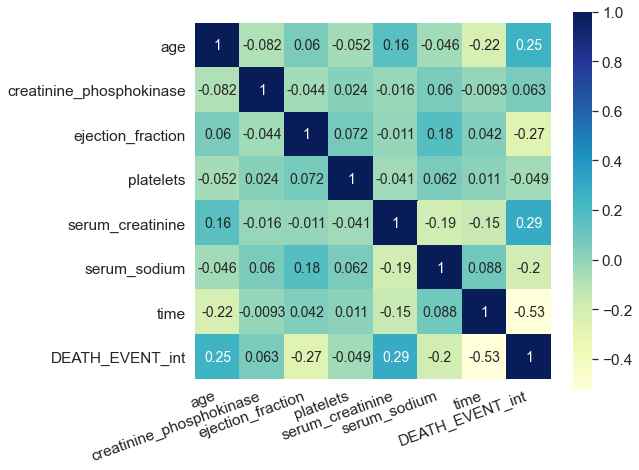

In [41]:
corr_1 = df.corr()

plt.figure(figsize=(9,7))
sns.set(font_scale=1.4)
sns.heatmap(corr_1, cmap='YlGnBu', annot_kws={"size": 14},
            annot=True, square=True, cbar_kws={'aspect':20})
plt.xticks(rotation=20, ha='right')
plt.tight_layout()

In [38]:
df[numerical].corrwith(df["DEATH_EVENT_int"]).to_frame('correlation')

,correlation
age,0.253729
creatinine_phosphokinase,0.062728
ejection_fraction,-0.268603
platelets,-0.049139
serum_creatinine,0.294278
serum_sodium,-0.195204
time,-0.526964


In [42]:
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ 
    Description: Calculates Cramer's V statistical correlation on categorical relationships
    Return: square root of correlation
    """
    try:
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
    except ValueError:
        return np.Nan
    
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    
    r,k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corrected = r - ((r-1)**2)/(n-1)
    k_corrected = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2_corrected / min((k_corrected-1), (r_corrected-1)))

def categorical_corr_matrix(dataframe):
    """ 
    Description: Screening correlation matrix for categorical variables
    Return: correlation matrix
    """
    categories = dataframe.select_dtypes(include='category')
    columns = categories.columns
    n = len(columns)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n,n)), index=columns, columns=columns)
    
    for column_1 in columns:
        for column_2 in columns:
            if column_1 == column_2:
                corr_matrix.loc[column_1, column_2] = 1
                break
            dataframe_crosstab = pd.crosstab(dataframe[column_1], dataframe[column_2], dropna=False)
            corr_matrix.loc[column_1, column_2] = cramers_corrected_stat(dataframe_crosstab)
    
    # Transpose to yield correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

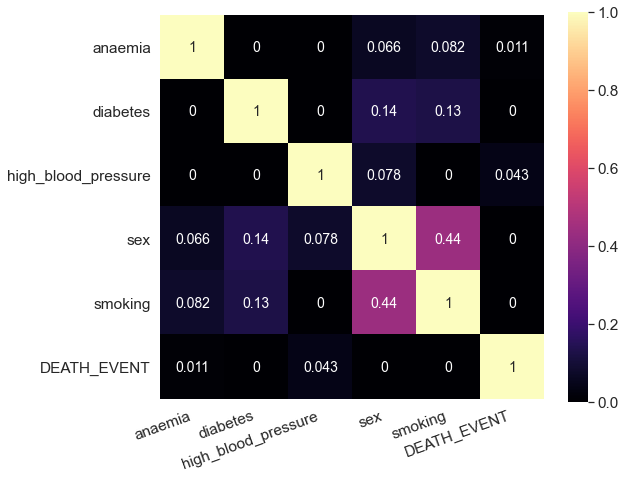

In [43]:
corr_2 = categorical_corr_matrix(df)

plt.figure(figsize=(9,7))
sns.set(font_scale=1.4)
sns.heatmap(corr_2, cmap='magma', annot_kws={"size": 14},
            annot=True, square=True, cbar_kws={'aspect':20})
plt.xticks(rotation=20, ha='right')
plt.tight_layout()

Analysis on feature correlations reveals a considerably high relationship on `DEATH_EVENT` with features `age`, `ejection_fraction`, `serum_creatinine`, and `time`.

### Distribution on Numerical (Continuous) Variables

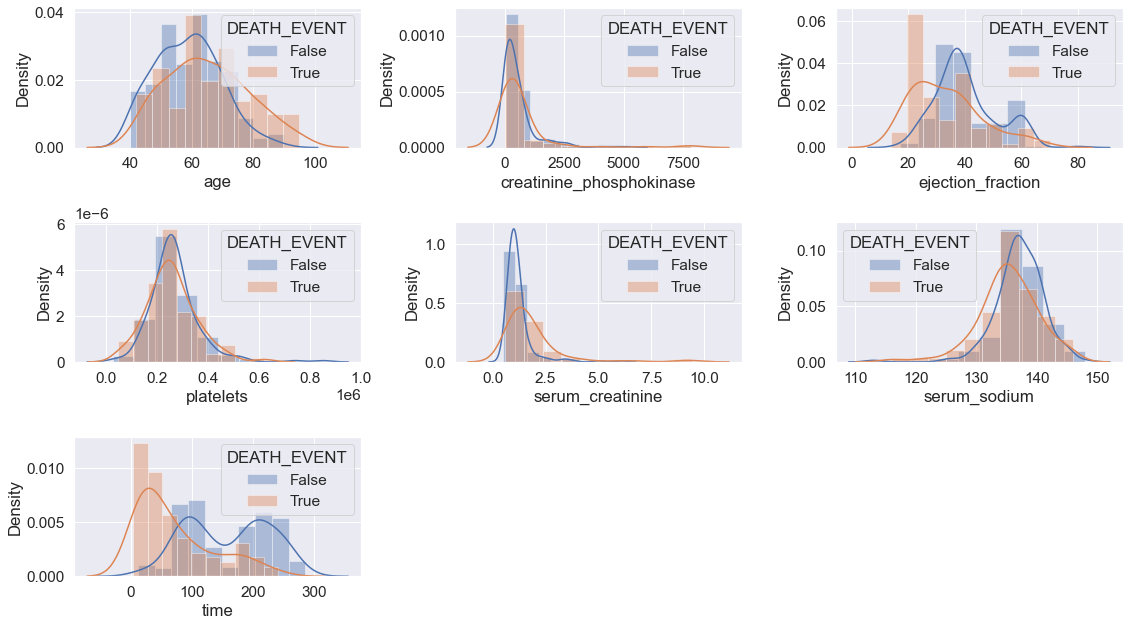

In [45]:
df_groupby = df.groupby('DEATH_EVENT_int')
fig, axis = plt.subplots(nrows=3, ncols=3, figsize=(16,9))
title = list(df.select_dtypes(exclude='category'))

ax_titles = zip(axis.flat, title)

for ax, title in ax_titles:
    sns.distplot(df_groupby.get_group(0)[title], bins=10, ax=ax, label='False')
    sns.distplot(df_groupby.get_group(1)[title], bins=10, ax=ax, label='True')
    ax.legend(title='DEATH_EVENT')
    
axis.flat[-1].remove()
axis.flat[-2].remove()
fig.tight_layout()

### Distribution on Categorical Variables

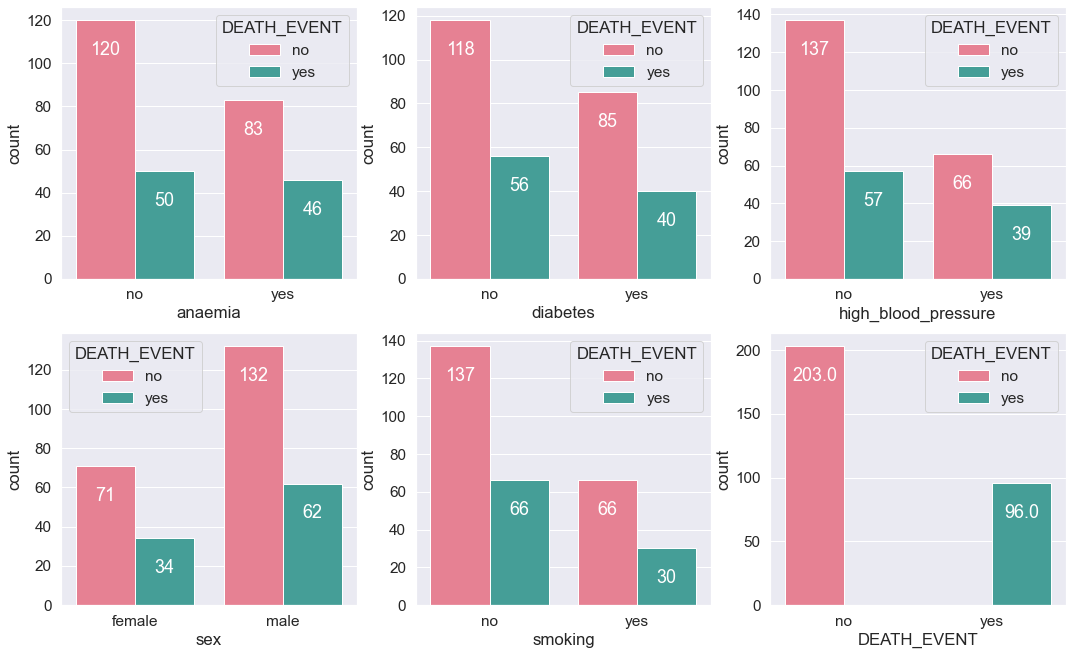

In [65]:
# plt.figure(figsize=(7,7))
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,11))
title = list(df.select_dtypes(exclude=['float64','int32','int64']))

ax_titles = zip(ax.flat, title)

for ax, title in ax_titles:
    ax = sns.countplot(x=title, hue="DEATH_EVENT", data=df, ax=ax, palette="husl")
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
# plt.xlabel('Sex', fontsize=16)
# plt.ylabel('Count', fontsize=16)
plt.show()

### Data Splitting

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = (X_train.DEATH_EVENT == 'yes').astype('int').values
y_test = (X_test.DEATH_EVENT == 'yes').astype('int').values

del X_train['DEATH_EVENT']
del X_test['DEATH_EVENT']

We count how many boolean values have on both train and test set.  

In [10]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([168,  71], dtype=int64))

In [11]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([35, 25], dtype=int64))

### Feature Engineering: One-hot Encoding

Calling `DictVectorizer` to turn lists of mappings of feature names and values into Numpy arrays.

In [12]:
from sklearn.feature_extraction import DictVectorizer

# Filling missing values with 0
dict_train = X_train.to_dict(orient='records')
dict_test = X_test.to_dict(orient='records')

In [13]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)

### Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

dt = DecisionTreeClassifier(criterion="gini", max_depth=30, min_samples_leaf=0.2,
                                  min_samples_split=0.5, 
                                  class_weight="balanced", random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=0.2, min_samples_split=0.5,
                       random_state=42)

In [15]:
# Prediction on training data
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9001928236083165

In [16]:
# Prediction on test data
y_pred = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.7948571428571427

In [17]:
dt_scores = []

max_depth_list = [10,20,30,40]
min_samples_leaf_list = [0.1, 0.2, 0.3]
min_samples_split_list = [0.3, 0.4, 0.5, 0.6]

for depth in max_depth_list:
    for samples_leaf in min_samples_leaf_list:
        for samples_split in min_samples_split_list:
            dt = DecisionTreeClassifier(criterion="gini", max_depth=depth, min_samples_leaf=samples_leaf,
                                      min_samples_split=samples_split, 
                                      class_weight="balanced", random_state=42)
            dt.fit(X_train, y_train)
            y_pred = dt.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred)

            dt_scores.append((depth, samples_leaf, samples_split, auc))

In [18]:
columns = ['max_depth', 'min_samples_leaf', 'min_samples_split', 'auc']
decision_tree_scores = pd.DataFrame(dt_scores, columns=columns)

In [19]:
decision_tree_scores.pivot(index='min_samples_leaf', 
                           columns=['max_depth','min_samples_split'], values=['auc'])

auc                                                    \
max_depth                10                                      20             
min_samples_split       0.3       0.4       0.5       0.6       0.3       0.4   
min_samples_leaf                                                                
0.1                0.811429  0.811429  0.811429  0.805143  0.811429  0.811429   
0.2                0.802857  0.802857  0.794857  0.794857  0.802857  0.802857   
0.3                0.791429  0.791429  0.791429  0.791429  0.791429  0.791429   

                                                                               \
max_depth                                    30                                 
min_samples_split       0.5       0.6       0.3       0.4       0.5       0.6   
min_samples_leaf                                                                
0.1                0.811429  0.805143  0.811429  0.811429  0.811429  0.805143   
0.2                0.794857  0.794857  0.802857  0.802857  0.794857  0.794857   
0.3                0.791429  0.791429  0.791429  0.791429  0.791429  0.791429   

                                                           
max_depth                40                                
min_samples_split       0.3       0.4       0.5       0.6  
min_samples_leaf                                           
0.1                0.811429  0.811429  0.811429  0.805143  
0.2                0.802857  0.802857  0.794857  0.794857  
0.3                0.791429  0.791429  0.791429  0.791429

We will choose each of parameter using pivot table with aggregation of maximum and minimum of AUC.

In [20]:
pd.pivot_table(decision_tree_scores, index='min_samples_leaf', values='auc', aggfunc=[np.max, np.min])

,amax,amin
,auc,auc
min_samples_leaf,,
0.1,0.811429,0.805143
0.2,0.802857,0.794857
0.3,0.791429,0.791429


In [21]:
pd.pivot_table(decision_tree_scores, index='max_depth', values='auc', aggfunc=[np.max, np.min])

,amax,amin
,auc,auc
max_depth,,
10,0.811429,0.791429
20,0.811429,0.791429
30,0.811429,0.791429
40,0.811429,0.791429


In [22]:
pd.pivot_table(decision_tree_scores, index='min_samples_split', values='auc', aggfunc=[np.max, np.min])

,amax,amin
,auc,auc
min_samples_split,,
0.3,0.811429,0.791429
0.4,0.811429,0.791429
0.5,0.811429,0.791429
0.6,0.805143,0.791429


In [23]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(criterion="gini", max_depth=30, min_samples_leaf= 0.1,
                                      min_samples_split=0.3, 
                                      class_weight="balanced", random_state=42)

model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_dt)

0.8114285714285714

In [25]:
import bentoml

bentoml.sklearn.save_model("heart_failure_model_decision_tree", model_dt,
                        custom_objects={
                            "dictVectorizer": dv
                            },
                        signatures = {
                            "predict_proba": 
                                {"batchable": False}}
                          )

Model(tag="heart_failure_model_decision_tree:ulwoyzkzzkuts7fs", path="C:\Users\rizdi\bentoml\models\heart_failure_model_decision_tree\ulwoyzkzzkuts7fs\")

In [66]:
model_dt.predict(X_test)

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1])

In [62]:
y_pred_dt

array([0.70292887, 0.        , 0.2970297 , 0.92206367, 0.14758419,
       0.2970297 , 0.70292887, 0.14758419, 0.92206367, 0.2970297 ,
       0.14758419, 0.70292887, 0.2970297 , 0.14758419, 0.92206367,
       0.92206367, 0.14758419, 0.14758419, 0.92206367, 0.14758419,
       0.70292887, 0.70292887, 0.70292887, 0.92206367, 0.92206367,
       0.        , 0.        , 0.14758419, 0.2970297 , 0.        ,
       0.92206367, 0.        , 0.92206367, 0.92206367, 0.92206367,
       0.92206367, 0.14758419, 0.2970297 , 0.14758419, 0.14758419,
       0.92206367, 0.70292887, 0.14758419, 0.14758419, 0.70292887,
       0.2970297 , 0.2970297 , 0.        , 0.        , 0.        ,
       0.70292887, 0.        , 0.2970297 , 0.        , 0.        ,
       0.92206367, 0.70292887, 0.92206367, 0.        , 0.92206367])

In [71]:
y_test

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1])

In [72]:
dict_test[2]

{'age': 45.0,
 'anaemia': 'no',
 'creatinine_phosphokinase': 2442,
 'diabetes': 'yes',
 'ejection_fraction': 30,
 'high_blood_pressure': 'no',
 'platelets': 334000.0,
 'serum_creatinine': 1.1,
 'serum_sodium': 139,
 'sex': 'male',
 'smoking': 'no',
 'time': 129}

In [68]:
X_test[1]

array([5.00e+01, 0.00e+00, 1.00e+00, 2.98e+02, 1.00e+00, 0.00e+00,
       3.50e+01, 1.00e+00, 0.00e+00, 3.62e+05, 9.00e-01, 1.40e+02,
       0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 2.40e+02])

### Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_scores = []

for d in [5, 7, 9, 11]:
    for n in range(100, 301, 10):
        for s in [0.6, 0.8, 1.0]:
            rf = RandomForestClassifier(oob_score=True, 
                                        class_weight="balanced", n_jobs=-1, 
                                        n_estimators=n,
                                        max_depth=d,
                                        max_samples=s,
                                        random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
            rf_scores.append((d, n, s, auc))

In [27]:
columns = ['max_depth', 'n_estimators', 'max_samples', 'auc']
df_scores = pd.DataFrame(rf_scores, columns=columns)

In [28]:
pivot_rf_scores = df_scores.pivot(index='n_estimators', 
                           columns=['max_depth','max_samples'], values=['auc'])

In [29]:
pivot_rf_scores

auc                                                    \
max_depth           5                             7                        
max_samples        0.6       0.8       1.0       0.6       0.8       1.0   
n_estimators                                                               
100           0.870857  0.850286  0.851429  0.856000  0.837714  0.851429   
110           0.875429  0.849143  0.854857  0.858286  0.836571  0.856000   
120           0.870857  0.843429  0.857143  0.852571  0.837714  0.856000   
130           0.872000  0.844571  0.858286  0.859429  0.838857  0.851429   
140           0.876571  0.841143  0.856000  0.857143  0.843429  0.851429   
150           0.869714  0.843429  0.860571  0.860571  0.844571  0.852571   
160           0.866286  0.846857  0.861714  0.859429  0.843429  0.850286   
170           0.866286  0.844571  0.860571  0.857143  0.840000  0.850286   
180           0.864000  0.845714  0.861714  0.856000  0.845714  0.852571   
190           0.865143  0.844571  0.852571  0.853714  0.844571  0.848000   
200           0.861714  0.844571  0.851429  0.854857  0.838857  0.852571   
210           0.861714  0.848000  0.852571  0.854857  0.842286  0.849143   
220           0.866286  0.850286  0.851429  0.858286  0.843429  0.850286   
230           0.865143  0.849143  0.851429  0.858286  0.844571  0.849143   
240           0.864000  0.850286  0.851429  0.860571  0.843429  0.848000   
250           0.861714  0.851429  0.852571  0.861714  0.846857  0.845714   
260           0.864000  0.853714  0.851429  0.858286  0.845714  0.849143   
270           0.862857  0.854857  0.852571  0.858286  0.844571  0.846857   
280           0.860571  0.854857  0.850286  0.861714  0.844571  0.846857   
290           0.862857  0.851429  0.848000  0.857143  0.842286  0.845714   
300           0.860571  0.854857  0.846857  0.852571  0.845714  0.848000   

                                                                          
max_depth           9                             11                      
max_samples        0.6       0.8       1.0       0.6       0.8       1.0  
n_estimators                                                              
100           0.866857  0.849143  0.852000  0.870286  0.858857  0.858857  
110           0.863429  0.848571  0.848571  0.871429  0.858286  0.855429  
120           0.858286  0.857143  0.849143  0.862857  0.858286  0.855429  
130           0.861714  0.856000  0.846857  0.865143  0.861143  0.856000  
140           0.861143  0.853714  0.845714  0.863429  0.855429  0.850857  
150           0.852571  0.851429  0.849143  0.863429  0.852571  0.854286  
160           0.851429  0.850286  0.850286  0.862286  0.854286  0.851429  
170           0.852571  0.846857  0.850286  0.856000  0.849714  0.850286  
180           0.856000  0.850286  0.848000  0.855429  0.850286  0.852571  
190           0.854857  0.850286  0.845714  0.856000  0.852000  0.856000  
200           0.858857  0.848000  0.846857  0.856571  0.852571  0.853143  
210           0.858857  0.846857  0.849143  0.855429  0.855429  0.849714  
220           0.861143  0.846857  0.845714  0.856000  0.856571  0.850286  
230           0.860000  0.848000  0.849143  0.860000  0.854286  0.850857  
240           0.860571  0.842286  0.850286  0.861714  0.844000  0.852000  
250           0.860571  0.842286  0.848000  0.858857  0.848571  0.852571  
260           0.862857  0.841143  0.848000  0.857143  0.845143  0.853714  
270           0.859429  0.844571  0.843429  0.858857  0.849143  0.849143  
280           0.862857  0.843429  0.842286  0.862286  0.846286  0.848571  
290           0.864000  0.846857  0.842286  0.861143  0.847429  0.849143  
300           0.862857  0.846857  0.848000  0.862286  0.850286  0.850286

In [30]:
pivot_rf_scores.unstack(level=0).unstack()

n_estimators                    100       110       120       130       140  \
    max_depth max_samples                                                     
auc 5         0.6          0.870857  0.875429  0.870857  0.872000  0.876571   
              0.8          0.850286  0.849143  0.843429  0.844571  0.841143   
              1.0          0.851429  0.854857  0.857143  0.858286  0.856000   
    7         0.6          0.856000  0.858286  0.852571  0.859429  0.857143   
              0.8          0.837714  0.836571  0.837714  0.838857  0.843429   
              1.0          0.851429  0.856000  0.856000  0.851429  0.851429   
    9         0.6          0.866857  0.863429  0.858286  0.861714  0.861143   
              0.8          0.849143  0.848571  0.857143  0.856000  0.853714   
              1.0          0.852000  0.848571  0.849143  0.846857  0.845714   
    11        0.6          0.870286  0.871429  0.862857  0.865143  0.863429   
              0.8          0.858857  0.858286  0.858286  0.861143  0.855429   
              1.0          0.858857  0.855429  0.855429  0.856000  0.850857   

n_estimators                    150       160       170       180       190  \
    max_depth max_samples                                                     
auc 5         0.6          0.869714  0.866286  0.866286  0.864000  0.865143   
              0.8          0.843429  0.846857  0.844571  0.845714  0.844571   
              1.0          0.860571  0.861714  0.860571  0.861714  0.852571   
    7         0.6          0.860571  0.859429  0.857143  0.856000  0.853714   
              0.8          0.844571  0.843429  0.840000  0.845714  0.844571   
              1.0          0.852571  0.850286  0.850286  0.852571  0.848000   
    9         0.6          0.852571  0.851429  0.852571  0.856000  0.854857   
              0.8          0.851429  0.850286  0.846857  0.850286  0.850286   
              1.0          0.849143  0.850286  0.850286  0.848000  0.845714   
    11        0.6          0.863429  0.862286  0.856000  0.855429  0.856000   
              0.8          0.852571  0.854286  0.849714  0.850286  0.852000   
              1.0          0.854286  0.851429  0.850286  0.852571  0.856000   

n_estimators               ...       210       220       230       240  \
    max_depth max_samples  ...                                           
auc 5         0.6          ...  0.861714  0.866286  0.865143  0.864000   
              0.8          ...  0.848000  0.850286  0.849143  0.850286   
              1.0          ...  0.852571  0.851429  0.851429  0.851429   
    7         0.6          ...  0.854857  0.858286  0.858286  0.860571   
              0.8          ...  0.842286  0.843429  0.844571  0.843429   
              1.0          ...  0.849143  0.850286  0.849143  0.848000   
    9         0.6          ...  0.858857  0.861143  0.860000  0.860571   
              0.8          ...  0.846857  0.846857  0.848000  0.842286   
              1.0          ...  0.849143  0.845714  0.849143  0.850286   
    11        0.6          ...  0.855429  0.856000  0.860000  0.861714   
              0.8          ...  0.855429  0.856571  0.854286  0.844000   
              1.0          ...  0.849714  0.850286  0.850857  0.852000   

n_estimators                    250       260       270       280       290  \
    max_depth max_samples                                                     
auc 5         0.6          0.861714  0.864000  0.862857  0.860571  0.862857   
              0.8          0.851429  0.853714  0.854857  0.854857  0.851429   
              1.0          0.852571  0.851429  0.852571  0.850286  0.848000   
    7         0.6          0.861714  0.858286  0.858286  0.861714  0.857143   
              0.8          0.846857  0.845714  0.844571  0.844571  0.842286   
              1.0          0.845714  0.849143  0.846857  0.846857  0.845714   
    9         0.6          0.860571  0.862857  0.859429  0.862857  0.864000   
              0.8          0.842286  0

In [31]:
unstack_rf_score = pivot_rf_scores.unstack(level=0).unstack()


In [32]:
unstack_rf_score.index

MultiIndex([('auc',  5, 0.6),
            ('auc',  5, 0.8),
            ('auc',  5, 1.0),
            ('auc',  7, 0.6),
            ('auc',  7, 0.8),
            ('auc',  7, 1.0),
            ('auc',  9, 0.6),
            ('auc',  9, 0.8),
            ('auc',  9, 1.0),
            ('auc', 11, 0.6),
            ('auc', 11, 0.8),
            ('auc', 11, 1.0)],
           names=[None, 'max_depth', 'max_samples'])

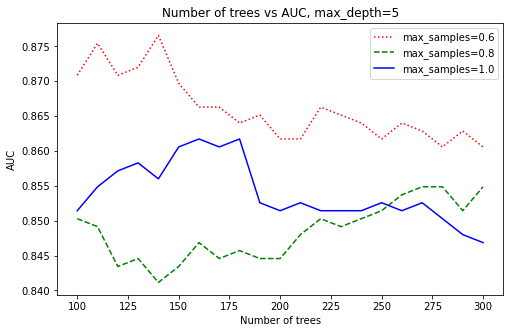

In [33]:
plt.figure(figsize=(8, 5))

num_trees = list(range(100, 301, 10))
plt.plot(num_trees, unstack_rf_score.loc[('auc',  5, 0.6)], label='max_samples=0.6', color='red', linestyle='dotted')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  5, 0.8)], label='max_samples=0.8', color='green', linestyle='dashed')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  5, 1.0)], label='max_samples=1.0', color='blue', linestyle='solid')
plt.title('Number of trees vs AUC, max_depth=5')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.legend()

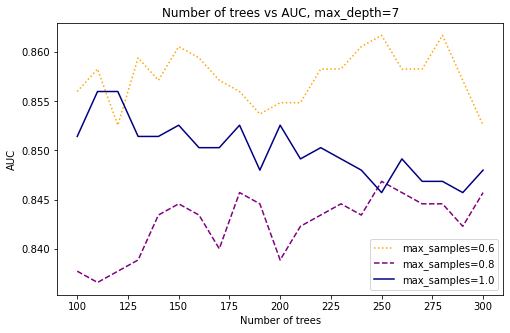

In [34]:
plt.figure(figsize=(8, 5))

num_trees = list(range(100, 301, 10))
plt.plot(num_trees, unstack_rf_score.loc[('auc',  7, 0.6)], label='max_samples=0.6', color='orange', linestyle='dotted')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  7, 0.8)], label='max_samples=0.8', color='purple', linestyle='dashed')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  7, 1.0)], label='max_samples=1.0', color='navy', linestyle='solid')
plt.title('Number of trees vs AUC, max_depth=7')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.legend()

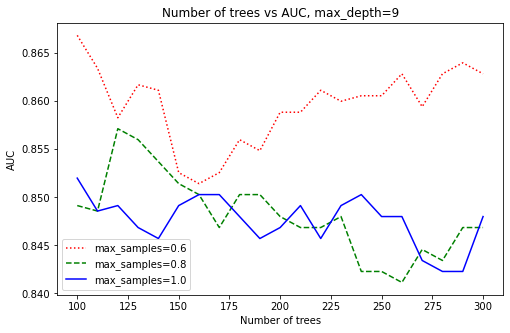

In [35]:
plt.figure(figsize=(8, 5))

num_trees = list(range(100, 301, 10))
plt.plot(num_trees, unstack_rf_score.loc[('auc',  9, 0.6)], label='max_samples=0.6', color='red', linestyle='dotted')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  9, 0.8)], label='max_samples=0.8', color='green', linestyle='dashed')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  9, 1.0)], label='max_samples=1.0', color='blue', linestyle='solid')
plt.title('Number of trees vs AUC, max_depth=9')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.legend()

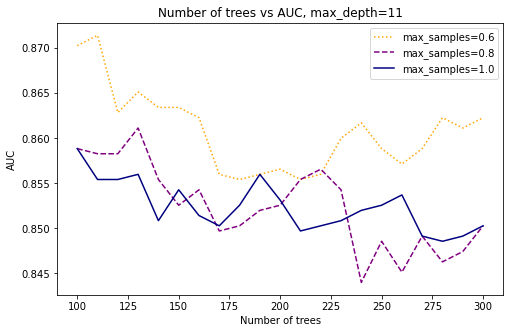

In [36]:
plt.figure(figsize=(8, 5))

num_trees = list(range(100, 301, 10))
plt.plot(num_trees, unstack_rf_score.loc[('auc',  11, 0.6)], label='max_samples=0.6', color='orange', linestyle='dotted')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  11, 0.8)], label='max_samples=0.8', color='purple', linestyle='dashed')
plt.plot(num_trees, unstack_rf_score.loc[('auc',  11, 1.0)], label='max_samples=1.0', color='navy', linestyle='solid')
plt.title('Number of trees vs AUC, max_depth=11')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.legend()

As usual, pivot table is used to choose the best value of each parameter.

In [37]:
pd.pivot_table(df_scores, index='max_samples', values='auc', aggfunc=[np.max, np.min])

,amax,amin
,auc,auc
max_samples,,
0.6,0.876571,0.851429
0.8,0.861143,0.836571
1.0,0.861714,0.842286


In [38]:
pd.pivot_table(df_scores, index='n_estimators', values='auc', aggfunc=[np.max, np.min])

,amax,amin
,auc,auc
n_estimators,,
100,0.870857,0.837714
110,0.875429,0.836571
120,0.870857,0.837714
130,0.872000,0.838857
140,0.876571,0.841143
150,0.869714,0.843429
160,0.866286,0.843429
170,0.866286,0.840000


In [39]:
pd.pivot_table(df_scores, index='max_depth', values='auc', aggfunc=[np.max, np.min])

,amax,amin
,auc,auc
max_depth,,
5,0.876571,0.841143
7,0.861714,0.836571
9,0.866857,0.841143
11,0.871429,0.844000


In [40]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(oob_score=True, 
                                        class_weight="balanced", n_jobs=-1, 
                                        n_estimators=140,
                                        max_depth=5,
                                        max_samples=0.6,
                                        random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_samples=0.6,
                       n_estimators=140, n_jobs=-1, oob_score=True,
                       random_state=42)

In [41]:
y_pred_rf = model_rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_rf)

0.8765714285714286

In [73]:
bentoml.sklearn.save_model("heart_failure_model_random_forest", model_rf,
                        custom_objects={
                            "dictVectorizer": dv
                            },
                        signatures = {
                            "predict_proba": 
                                {"batchable": False}}
                          )

Model(tag="heart_failure_model_random_forest:jdzn3pcz3ouwy7fs", path="C:\Users\rizdi\bentoml\models\heart_failure_model_random_forest\jdzn3pcz3ouwy7fs\")

In [81]:
model_rf.predict(X_test)

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [74]:
y_pred_rf

array([0.41113793, 0.05109905, 0.19640501, 0.85168451, 0.19037482,
       0.13290722, 0.56728519, 0.14139968, 0.69236059, 0.28944532,
       0.14022263, 0.28090252, 0.35596449, 0.15534764, 0.47944962,
       0.59758394, 0.08484228, 0.20002386, 0.42618714, 0.35232259,
       0.49230145, 0.33048995, 0.50366893, 0.64021035, 0.68766268,
       0.0860188 , 0.14132029, 0.12596586, 0.345487  , 0.1487945 ,
       0.62267564, 0.07166425, 0.71092575, 0.87197643, 0.71327829,
       0.64393034, 0.21833476, 0.4787194 , 0.21602296, 0.11470501,
       0.3826654 , 0.57838436, 0.14405326, 0.1762665 , 0.3446407 ,
       0.12959718, 0.38945556, 0.14877691, 0.11186801, 0.17745365,
       0.43743678, 0.15572402, 0.24556992, 0.08167667, 0.22408858,
       0.33468499, 0.28049029, 0.74827222, 0.12082656, 0.80845574])

In [75]:
y_test

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1])

### XGBoost Classifier

In [43]:
import xgboost as xgb

features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [44]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [45]:
y_pred = model.predict(dtest)
y_pred[:10]

array([0.7516652 , 0.02758984, 0.14972427, 0.93566394, 0.06789354,
       0.04907303, 0.44291663, 0.12415204, 0.87839067, 0.2518211 ],
      dtype=float32)

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.842857142857143

In [47]:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

In [48]:
def parse_xgb_output(output):
    results = []    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

#### XGBoost Optimization with HyperOpt

Optimization, in mathematics perspective, is described as a process for a function to reaches a possible set of parameters that produces optimum solution. For machine learning, there are a few techniques that can help search space exploration to be much more efficient in time and efforts than grid-search and randomized-search CV. This section will see how optimization with HyperOpt gives a XGBoost model sets of parameters that yields an optimum return. 

More information on Hyperopt can be found at the following link: https://hyperopt.github.io/hyperopt/?source=post_page

Took inspiration from a kaggle https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#4.-Bayesian-Optimization-with-HYPEROPT-

In [49]:
# define a search space
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
        'eta': hp.uniform("eta", 0.1, 0.6, 0.1),
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'reg_alpha' : hp.quniform('reg_alpha', 50, 100, 2),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
    }

In [50]:
def objective(space):
    model = xgb.train(space, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)
    y_pred = model.predict(dtest)
    roc_auc = roc_auc_score(y_test, y_pred)
    print ("ROC-AUC:", roc_auc)
    return {'loss': -roc_auc, 'status': STATUS_OK }
    
    

In [51]:
def score(params):
    print("Training with params: ")
    print(params)
    
    features = dv.get_feature_names_out()
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    xgb_model = xgb.train(params, dtrain, num_boost_round=10,
                          evals=watchlist,
                          verbose_eval=True)
    y_pred = xgb_model.predict(dtest)
    roc_auc = roc_auc_score(y_test, y_pred)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(roc_auc))
    loss = 1 - roc_auc
    return {'loss': loss, 'status': STATUS_OK}

def optimize():
    space = {
        'eta': hp.quniform('eta', 0.1, 0.5, 0.05),
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        # 'reg_alpha' : hp.quniform('reg_alpha', 50, 100, 2),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'seed': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact'
    }
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=100)
    return best

In [52]:
best_hyperparams = optimize()
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

Training with params:                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.4, 'eval_metric': 'auc', 'max_depth': 9, 'min_child_weight': 3.0, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1, 'tree_method': 'exact'}
[0]	train-auc:0.76626	test-auc:0.68286                                                                                            
[1]	train-auc:0.86066	test-auc:0.74057                                                                                            
[2]	train-auc:0.96110	test-auc:0.84000                                                                                            
[3]	train-auc:0.97221	test-auc:0.86114                                                                                            
[4]	train-auc:0.97330	test-auc:0.87600                                                                                         

Following the suggestion from [MLZoomcamp FAQ](https://docs.google.com/document/d/1LpPanc33QJJ6BSsyxVg-pWNMplal84TdZtq10naIhD8/edit#), feature names are excluded from building memory-based training and test sets.

In [93]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [97]:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

In [98]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 11,
    'min_child_weight': 9.0,
    'colsample_bytree': 0.65,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'booster': 'gbtree',
    'tree_method': 'exact',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [99]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8822857142857143

In [100]:
model.predict(dtest)

array([0.4591532 , 0.00750474, 0.06163992, 0.8092941 , 0.01923679,
       0.12963356, 0.555367  , 0.02457393, 0.92704463, 0.08555408,
       0.03446347, 0.4843679 , 0.09980921, 0.08391189, 0.64087737,
       0.8831536 , 0.02004872, 0.05723193, 0.45030463, 0.05803424,
       0.640913  , 0.1309465 , 0.31311277, 0.9335614 , 0.85654914,
       0.02299946, 0.02610333, 0.03291748, 0.31276354, 0.01011169,
       0.96050954, 0.00705027, 0.8172469 , 0.9748915 , 0.8221764 ,
       0.7199868 , 0.03537639, 0.6112746 , 0.02329996, 0.0285714 ,
       0.72027093, 0.7080764 , 0.03915167, 0.02722987, 0.08328678,
       0.04731282, 0.12349378, 0.02394503, 0.01595785, 0.01823574,
       0.4705517 , 0.09568688, 0.20622079, 0.00736268, 0.06353675,
       0.5319683 , 0.31378612, 0.891108  , 0.04207518, 0.9535788 ],
      dtype=float32)

In [101]:
y_pred_hard = np.where(y_pred>0.5,1,0)
y_pred_hard

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

In [102]:
y_test

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1])

In [103]:
len(list(y_test))

60

Counting how many correct prediction XGBoost made on test set

In [104]:
y_pred_hard == y_test

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False,  True,  True,  True,  True])

In [105]:
sum(y_pred_hard == y_test)

46

Converting XGBoost output IO into Pandas table.

In [106]:
xgb_out1 = parse_xgb_output(output)
xgb_out1

,num_iter,train_auc,val_auc
0,0,0.67991,0.70857
1,5,0.95242,0.88286
2,10,0.95276,0.90000
3,15,0.95666,0.88914
4,20,0.95779,0.88571
5,25,0.95749,0.88800
6,30,0.95791,0.89029
7,35,0.95808,0.88800
8,40,0.95808,0.88686
9,45,0.95783,0.88686


In [107]:
print(max(xgb_out1['train_auc']))
print(max(xgb_out1['val_auc']))

0.96156
0.9


In [108]:
xgb_out1['diff'] = xgb_out1['train_auc'] - xgb_out1['val_auc']
xgb_out1

,num_iter,train_auc,val_auc,diff
0,0,0.67991,0.70857,-0.02866
1,5,0.95242,0.88286,0.06956
2,10,0.95276,0.90000,0.05276
3,15,0.95666,0.88914,0.06752
4,20,0.95779,0.88571,0.07208
5,25,0.95749,0.88800,0.06949
6,30,0.95791,0.89029,0.06762
7,35,0.95808,0.88800,0.07008
8,40,0.95808,0.88686,0.07122
9,45,0.95783,0.88686,0.07097


In [109]:
import bentoml

bentoml.xgboost.save_model("heart_failure_model", model,
                        custom_objects={
                            "dictVectorizer": dv
                            },
                            signatures={
                                "predict": {
                                    "batchable": False,
                                    "batch_dim": 0,
                                }
                            }
                    )

Model(tag="heart_failure_model:tm7remcz46j4e7fs", path="C:\Users\rizdi\bentoml\models\heart_failure_model\tm7remcz46j4e7fs\")